In [38]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd

import sys
sys.path.append('../../src/')
from afm_functions import parse_ibw, afm_RMS_roughness
from domain_analysis import find_histogram_peaks
from AFM_RHEED import visualize_afm_image_single

def plot_save_single_height(file, viz_parms, save=False):
    scan_size_converter = viz_parms['scan_size_converter']
    scalebar_dict_dict = viz_parms['scalebar_dict_dict']
    colorbar_range = viz_parms['colorbar_range']
    debug = viz_parms['debug']

    imgs, Sample_name, labels, scan_size = parse_ibw(file)
    height = imgs[:,:,0]
    filename = os.path.basename(file)
    # identifier = filename.split('_')[0]
    title = filename[:-9]+'-'+scan_size_converter[str(scan_size)]
    
    peaks, counts = find_histogram_peaks(height, num_peaks=1, distance=1, debug=debug)
    height_norm = height - peaks[0]
    # img = img - np.mean(img)
    peaks, counts = find_histogram_peaks(height_norm, num_peaks=1, distance=1, debug=debug)

    scalebar_dict = scalebar_dict_dict[str(scan_size)]
    print(file)
    visualize_afm_image_single(height_norm, colorbar_range=colorbar_range, figsize=(6,4), scalebar_dict=scalebar_dict, title=title)
    if save:
        plt.savefig(f'../../data/SRO/{title}.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'../../data/SRO/{title}.svg', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

    name = filename[:-9]
    scan_size = scan_size_converter[str(scan_size)]
    return height_norm, name, scan_size

def expand_xylim(extra_space=0.2):
    # Get current axis limits
    current_x_limits = plt.xlim()
    current_y_limits = plt.ylim()

    # Calculate expanded limits (let's expand by 20% for example)
    x_range = current_x_limits[1] - current_x_limits[0]
    y_range = current_y_limits[1] - current_y_limits[0]

    new_x_limits = (current_x_limits[0] - extra_space * x_range, current_x_limits[1] + extra_space * x_range)
    new_y_limits = (current_y_limits[0] - extra_space * y_range, current_y_limits[1] + extra_space * y_range)

    # Set new limits
    plt.xlim(new_x_limits)
    plt.ylim(new_y_limits)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
files = glob.glob('../../../Drexel_TSST_SRO/SRO_TSST-selected/*.ibw')

df = pd.read_excel('../../data/Sample log.xlsx', sheet_name='SRO')
df_condition = df.loc[16:24, ['Growth', 'Pressure (mTorr)', 'Temperature (C)', 'Fluence (J/cm2)', 'Repetation rate (Hz)']]
df_condition.replace('2 to 1.73', (2+1.73)/2, inplace=True)
df_condition.replace('700 (heater O)', 700, inplace=True)
df_condition.replace('650 (heater O)', 650, inplace=True)
df_condition

print('Pressure (mTorr):', df_condition['Pressure (mTorr)'].unique())
print('Temperature (C):', df_condition['Temperature (C)'].unique())
print('Fluence (J/cm2):', df_condition['Fluence (J/cm2)'].unique())
print('Repetation rate (Hz):', df_condition['Repetation rate (Hz)'].unique())

for file in files:
    imgs, Sample_name, labels, scan_size = parse_ibw(file)
    height = imgs[:,:,0]
    filename = os.path.basename(file)
    roughness = afm_RMS_roughness(height)
    roughness *= 1e9

    df_condition.loc[df['Growth']== filename[:5], f'RMS-{scan_size_converter[str(scan_size)]} (nm)'] = roughness
    # print(filename, roughness)
    # df_condition[f'RMS-{scan_size_converter[str(scan_size)]} (pm)'] = roughness
df_condition

Pressure (mTorr): [ 75. 100.]
Temperature (C): [700 650]
Fluence (J/cm2): [1.69285714 1.865      2.05       1.6       ]
Repetation rate (Hz): [10.  5.  2.]


,Growth,Pressure (mTorr),Temperature (C),Fluence (J/cm2),Repetation rate (Hz),RMS-5um (nm),RMS-3um (nm)
16,YG045,75.0,700,1.692857,10.0,3.212892,3.160401
17,YG046,75.0,700,1.865000,10.0,0.770325,0.744624
18,YG047,75.0,700,2.050000,10.0,3.229607,3.360073
19,YG048,75.0,700,2.050000,5.0,1.244350,1.081943
20,YG049,75.0,700,2.050000,2.0,7.190207,9.395419
21,YG050,100.0,700,2.050000,5.0,4.735755,2.337198
22,YG051,75.0,700,2.050000,5.0,2.948058,2.979771
23,YG052,75.0,650,2.050000,5.0,1.523082,1.449265
24,YG053,75.0,700,1.600000,5.0,0.231402,0.197540


In [41]:
files = glob.glob('../../../Drexel_TSST_SRO/SRO_TSST-selected/*.ibw')
data = {}
for file in files:
    imgs, Sample_name, labels, scan_size = parse_ibw(file)
    height = imgs[:,:,0]
    filename = os.path.basename(file)
    roughness = afm_RMS_roughness(height)
    roughness *= 1e9

    column_name = f'RMS-{scan_size_converter[str(scan_size)]} (nm)'
    if filename[:-9] not in data:
        data[filename[:-9]] = {'Growth': filename[:-9]}
    data[filename[:-9]][column_name] = roughness

df_afm = pd.DataFrame(list(data.values()))
# df_afm

# Example Python code to standardize 'Growth' identifiers
df_condition['Standardized Growth'] = df_condition['Growth'].str.extract('(YG\d+)')  # Regex to extract basic YG### format
df_afm['Standardized Growth'] = df_afm['Growth'].str.extract('(YG\d+)')
# Merging the dataframes
result_df = pd.merge(df_condition, df_afm, on='Standardized Growth', suffixes=('_df1', '_df2'))
# result_df

# merge condition and afm data
result_df.drop(columns=['Growth_df1', 'Standardized Growth', 'RMS-5um (nm)_df1', 'RMS-3um (nm)_df1'], inplace=True)
result_df.rename(columns={'Growth_df2': 'Growth'}, inplace=True)
result_df.rename(columns={'RMS-5um (nm)_df2': 'RMS-5um (nm)'}, inplace=True)
result_df.rename(columns={'RMS-3um (nm)_df2': 'RMS-3um (nm)'}, inplace=True)
Growth = result_df.pop('Growth')
result_df.insert(0, 'Growth', Growth)
df_all = result_df
df_all

,Growth,Pressure (mTorr),Temperature (C),Fluence (J/cm2),Repetation rate (Hz),RMS-5um (nm),RMS-3um (nm)
0,YG045,75.0,700,1.692857,10.0,3.212892,3.160401
1,YG046,75.0,700,1.865000,10.0,0.770325,0.744624
2,YG047,75.0,700,2.050000,10.0,3.229607,3.360073
3,YG048,75.0,700,2.050000,5.0,1.244350,1.081943
4,YG049,75.0,700,2.050000,2.0,7.190207,9.395419
5,YG050,100.0,700,2.050000,5.0,4.735755,2.337198
6,YG051_tr2_s2,75.0,700,2.050000,5.0,0.765376,0.687991
7,YG051_untr2,75.0,700,2.050000,5.0,3.013499,3.107707
8,YG051_untr3,75.0,700,2.050000,5.0,2.948058,2.979771
9,YG052_piece1,75.0,650,2.050000,5.0,2.126825,2.359813


In [42]:
# add file path to the dataframe
files_3um = glob.glob('../../data/SRO/*3um.svg')
files_5um = glob.glob('../../data/SRO/*5um.svg')
df_all['Path 3um'] = files_3um
df_all['Path 5um'] = files_5um
df_all

,Growth,Pressure (mTorr),Temperature (C),Fluence (J/cm2),Repetation rate (Hz),RMS-5um (nm),RMS-3um (nm),Path 3um,Path 5um
0,YG045,75.0,700,1.692857,10.0,3.212892,3.160401,../../data/SRO\YG045-3um.svg,../../data/SRO\YG045-5um.svg
1,YG046,75.0,700,1.865000,10.0,0.770325,0.744624,../../data/SRO\YG046-3um.svg,../../data/SRO\YG046-5um.svg
2,YG047,75.0,700,2.050000,10.0,3.229607,3.360073,../../data/SRO\YG047-3um.svg,../../data/SRO\YG047-5um.svg
3,YG048,75.0,700,2.050000,5.0,1.244350,1.081943,../../data/SRO\YG048-3um.svg,../../data/SRO\YG048-5um.svg
4,YG049,75.0,700,2.050000,2.0,7.190207,9.395419,../../data/SRO\YG049-3um.svg,../../data/SRO\YG049-5um.svg
5,YG050,100.0,700,2.050000,5.0,4.735755,2.337198,../../data/SRO\YG050-3um.svg,../../data/SRO\YG050-5um.svg
6,YG051_tr2_s2,75.0,700,2.050000,5.0,0.765376,0.687991,../../data/SRO\YG051_tr2_s2-3um.svg,../../data/SRO\YG051_tr2_s2-5um.svg
7,YG051_untr2,75.0,700,2.050000,5.0,3.013499,3.107707,../../data/SRO\YG051_untr2-3um.svg,../../data/SRO\YG051_untr2-5um.svg
8,YG051_untr3,75.0,700,2.050000,5.0,2.948058,2.979771,../../data/SRO\YG051_untr3-3um.svg,../../data/SRO\YG051_untr3-5um.svg
9,YG052_piece1,75.0,650,2.050000,5.0,2.126825,2.359813,../../data/SRO\YG052_piece1-3um.svg,../../data/SRO\YG052_piece1-5um.svg


YG045 75.0 3.212892471220419
AnnotationBbox(75,3.21289) [] 75.0 3.212892471220419
YG046 75.0 0.7703254021326663
AnnotationBbox(75,0.770325) [<matplotlib.offsetbox.AnnotationBbox object at 0x000001B00741A248>] 75.0 0.7703254021326663
75.03976368490903
YG047 75.0 3.229606849721341
AnnotationBbox(75,3.22961) [<matplotlib.offsetbox.AnnotationBbox object at 0x000001B00741A248>, <matplotlib.offsetbox.AnnotationBbox object at 0x000001B0063218C8>] 75.5 3.729606849721341
75.00177993720516
75.0583596056165


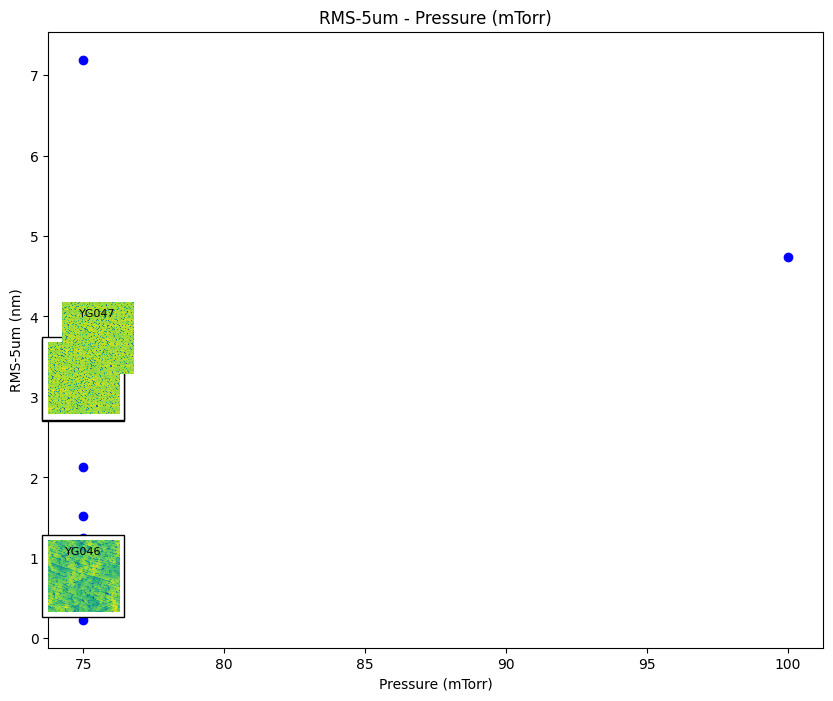

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def check_overlap(test_box, boxes, delta=5):
    """ Check if a box overlaps with a list of boxes and adjust position """
    x, y = test_box.xy
    while any([np.hypot(box.xy[0] - x, box.xy[1] - y) < delta for box in boxes]):
        x += delta  # Move right more significantly to avoid overlap
        y += delta  # Move up
    return x, y

from adjustText import adjust_text
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

for k in ['Pressure (mTorr)', 'Temperature (C)', 'Fluence (J/cm2)', 'Repetation rate (Hz)'][:1]:
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(df_all[k], df_all['RMS-5um (nm)'], c='blue')

    # Load and display images without overlap
    boxes = []
    for x, y, g in zip(df_all[k], df_all['RMS-5um (nm)'], df_all['Growth'][:3]):
        print(g, x, y)
        img = height_5um_dict[g]
        imagebox = OffsetImage(img, zoom=0.2)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(AnnotationBbox(imagebox, (x, y), frameon=True, alpha=0.2))  # Show initial position faintly

        delta = 0.5
        # Adjust position if overlaps
        x_new, y_new = check_overlap(ab, boxes, delta=delta)
        print(ab, boxes, x_new, y_new)
        for box in boxes:
            print(np.hypot(box.xy[0], box.xy[1] - y_new))

        ab.xybox = (x_new, y_new)
        ax.add_artist(ab)
        boxes.append(ab)
    
        # Add title for each image
        ax.text(x_new, y_new + delta * 0.5, f'{g}', fontsize=8, ha='center', va='bottom')

    plt.title(f'RMS-5um - {k}')
    plt.xlabel(k)
    plt.ylabel('RMS-5um (nm)')
    plt.show()

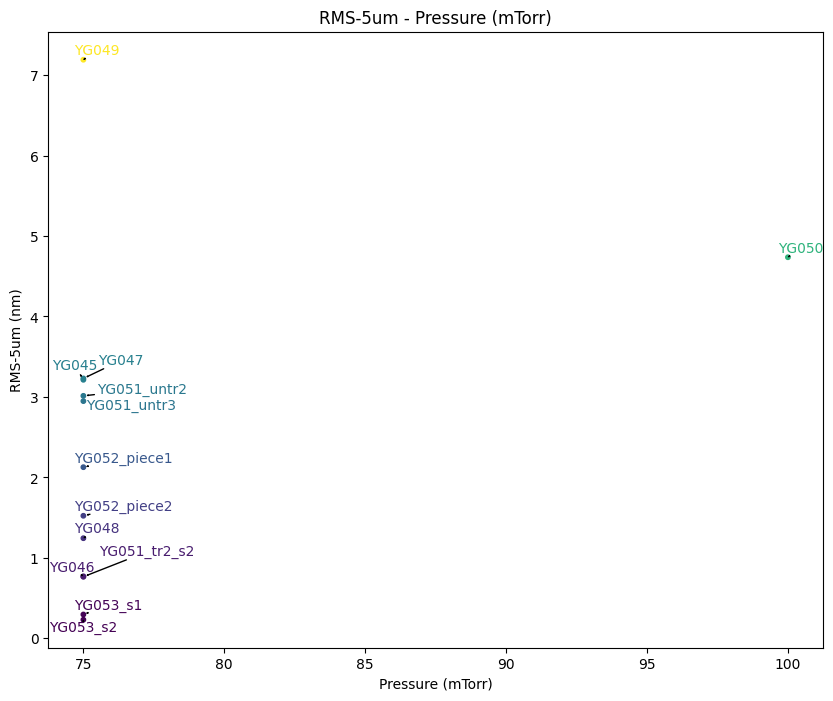

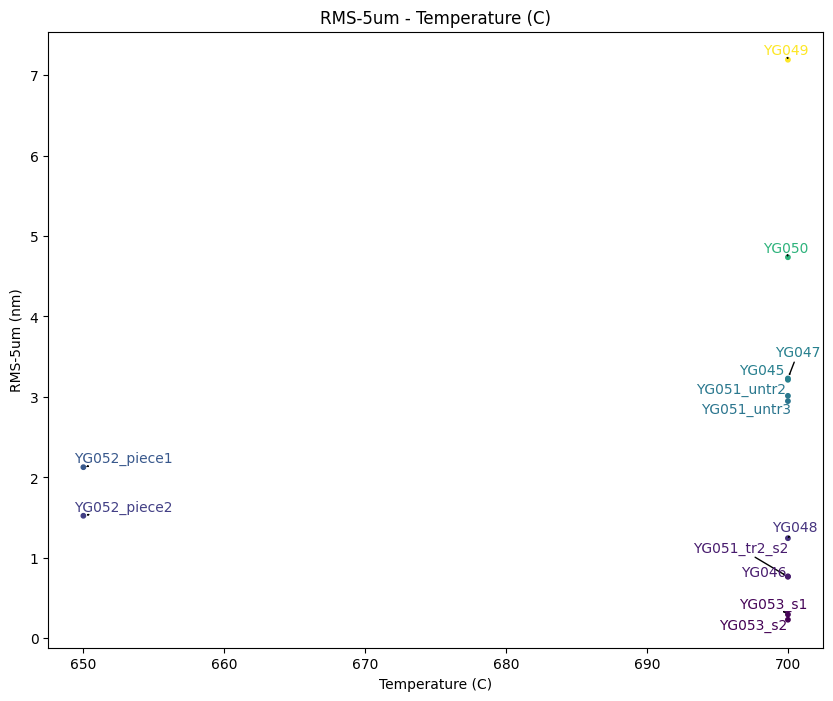

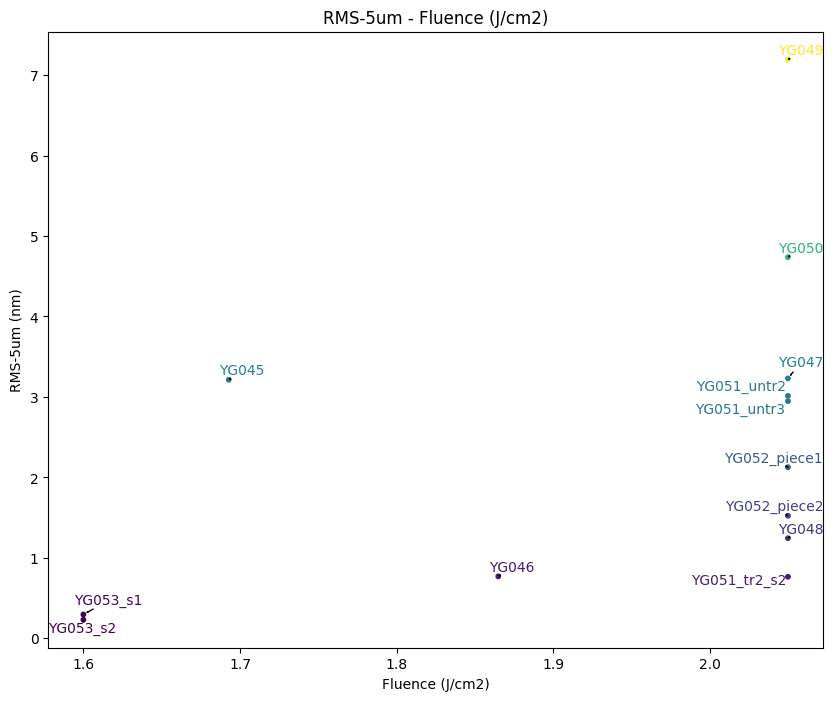

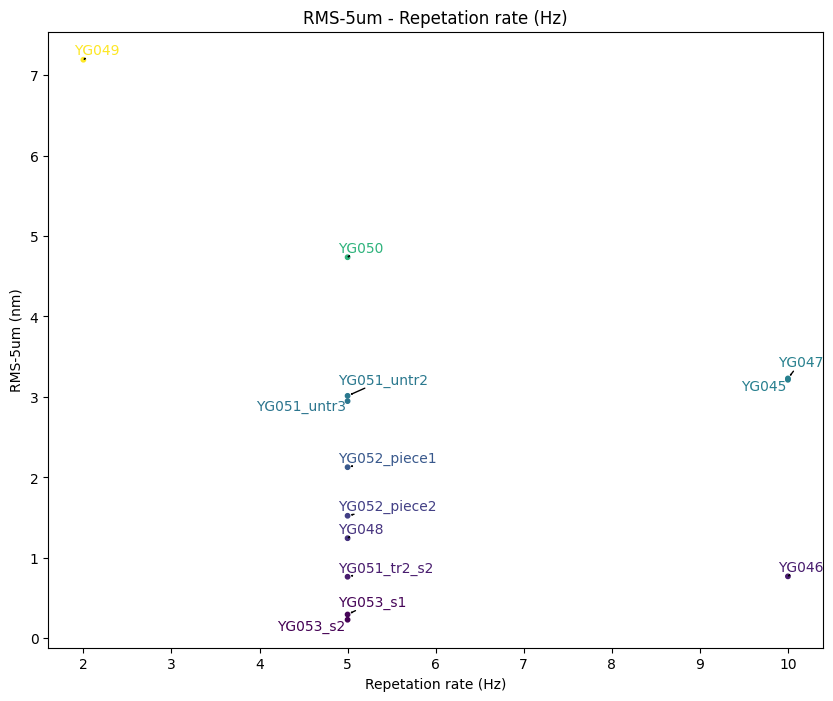

In [42]:
from adjustText import adjust_text
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
files = glob.glob('../../data/SRO/*-5um.png')

for k in list(df_all.columns[1:5]):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Normalize the 'RMS-5um (nm)' values to [0, 1] for colormap application
    norm = plt.Normalize(df_all['RMS-5um (nm)'].min(), df_all['RMS-5um (nm)'].max())
    colors = plt.cm.viridis(norm(df_all['RMS-5um (nm)']))

    # Scatter plot with unified color mapping
    scatter = ax.scatter(df_all[k], df_all['RMS-5um (nm)'], marker='o', c=colors, s=10)

    # Adding text annotations with unified viridis colormap
    texts = []
    for i, point in df_all.iterrows():
        texts.append(ax.text(point[k], point['RMS-5um (nm)'], f'{point["Growth"]}',
                             color=colors[i], ha='right'))  # Apply same colormap to text

    # Use adjust_text to automatically adjust the positions of the annotations
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

    plt.title(f'RMS-5um - {k}')
    plt.xlabel(k)
    plt.ylabel('RMS-5um (nm)')
    
    filename = f'../../data/SRO/RMS-5um (nm) with {k}.png'
    filename = filename.replace('(J/cm2)', '(J cm-2)')
    # print(filename) 
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

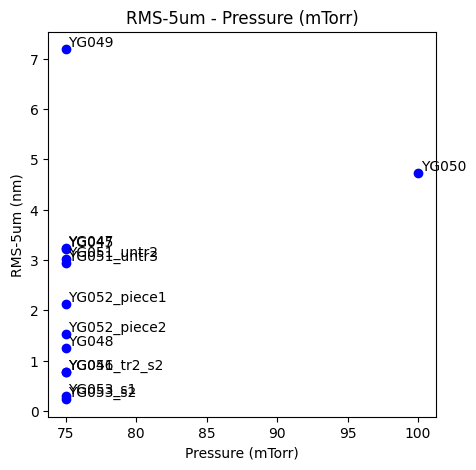

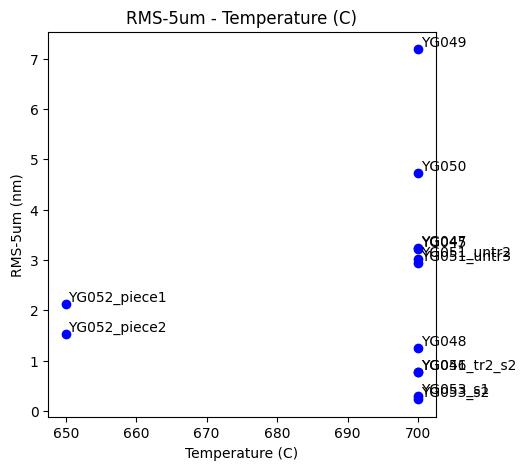

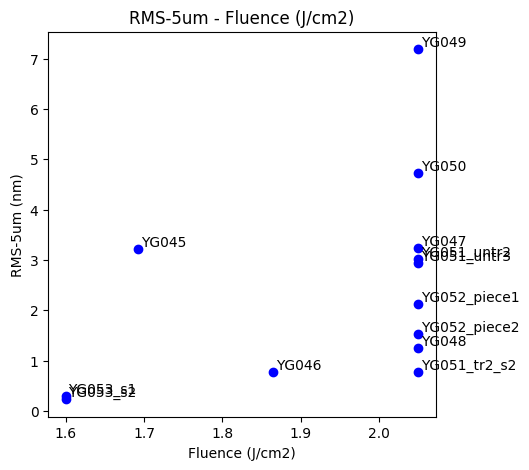

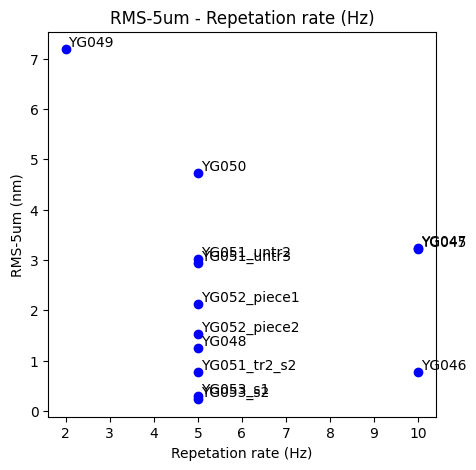

In [10]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
files = glob.glob('../../data/SRO/*-5um.png')

for k in list(df_all.columns[1:5]):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    plt.scatter(df_all[k], df_all['RMS-5um (nm)'], c='blue', marker='o')

    # Adding text annotations
    for i, point in df_all.iterrows():
        # ax.annotate(f'{point["Growth"]}-RMS:{point["RMS-5um (nm)"]:.2f}nm', (point[k], point['RMS-5um (nm)']), 
        #             textcoords="offset points", xytext=(0,10), ha='center')
        ax.annotate(f'{point["Growth"]}', (point[k], point['RMS-5um (nm)']), 
                    textcoords="offset points", xytext=(2,2), ha='left')
    # for i, (x, y, path) in enumerate(zip(df_all[k], df_all['RMS-5um (nm)'], files)):
    #     # Load the image, note plt.imread assumes that you have images in a format that matplotlib can read
    #     img = plt.imread(path)
    #     imagebox = OffsetImage(img, zoom=0.05)  # Adjust 'zoom' as necessary
    #     if i % 2 == 0:
    #         ab = AnnotationBbox(imagebox, (x*1.1, y), frameon=False, pad=0.5)
    #     else:
    #         ab = AnnotationBbox(imagebox, (x*0.9, y), frameon=False, pad=0.5)
    #     ax.add_artist(ab)

    plt.title(f'RMS-5um - {k}')
    plt.xlabel(k)
    plt.ylabel('RMS-5um (nm)')
    plt.show()